# Predicting Diabetes Using BRFSS Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.metrics import make_scorer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Diabetes_2022.csv')

In [4]:
y = df.Diabetes_01
X = df.drop(['Diabetes_01'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (228311, 24) X_test: (57078, 24)
y_train: (228311,) y_test: (57078,)


### ADASYN

In [7]:
adasyn = ADASYN(random_state=2)
X_adasyn_sampled, y_adasyn_sampled = adasyn.fit_resample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_adasyn_sampled)))


Original dataset shape Counter({0: 192370, 1: 35941})
Resampled dataset shape Counter({1: 193718, 0: 192370})


## Modeling

In [8]:
def optimize_model(model, param_grid, primary_metric="recall", cv=5, X_train = X_train, y_train = y_train):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score)
    }
    optimizer = GridSearchCV(estimator=model, 
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit=primary_metric, 
                             cv=cv, 
                             n_jobs=-1, 
                             verbose=True)
    
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print(f'\nBest {primary_metric} score: %0.6f' % (optimizer.best_score_))

    if primary_metric == 'recall':
        print(f"Corresponding accuracy: {optimizer.cv_results_['mean_test_accuracy'][optimizer.best_index_]:0.6f}")
    else:
        print(f"Corresponding recall: {optimizer.cv_results_['mean_test_recall'][optimizer.best_index_]:0.6f}")
    
    return optimizer.best_estimator_

In [9]:
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [10]:
lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.685098

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     48132
           1       0.28      0.66      0.40      8946

    accuracy                           0.69     57078
   macro avg       0.60      0.68      0.59     57078
weighted avg       0.82      0.69      0.73     57078



In [11]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200]
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}
grid_search = GridSearchCV(estimator=lr_baseline, param_grid=param_grid, scoring=scoring, refit='recall', cv=5)
grid_search.fit(X_adasyn_sampled, y_adasyn_sampled)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_recall_score = grid_search.best_score_
print("Best Recall Score (used for refit):", best_recall_score)
best_index = grid_search.best_index_  
best_accuracy_score = grid_search.cv_results_['mean_test_accuracy'][best_index]
print("Best Accuracy Score:", best_accuracy_score)

Best Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Recall Score (used for refit): 0.7116738656029937
Best Accuracy Score: 0.7003740490692628


In [12]:
lr_model = grid_search.best_estimator_ 

<Figure size 200x100 with 0 Axes>

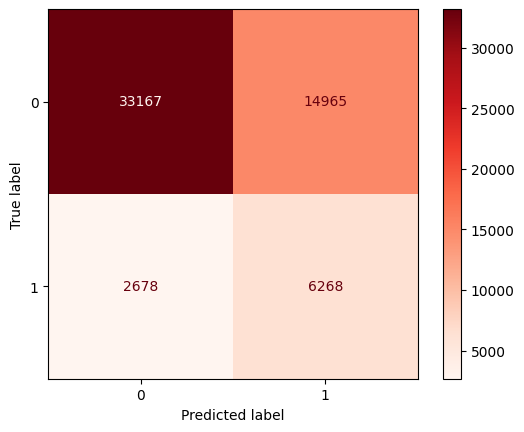

In [13]:
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


### Decision Tree Classifier

In [14]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

In [15]:
tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.703213

Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.75      0.81     48132
           1       0.25      0.44      0.31      8946

    accuracy                           0.70     57078
   macro avg       0.56      0.59      0.56     57078
weighted avg       0.78      0.70      0.73     57078



In [16]:
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 30, 'model__min_samples_leaf': 5}

Best recall score: 0.257283
Corresponding accuracy: 0.815134

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48132
           1       0.38      0.26      0.31      8946

    accuracy                           0.82     57078
   macro avg       0.62      0.59      0.60     57078
weighted avg       0.79      0.82      0.80     57078



In [18]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy'))])
tree_param_grid = {'model__min_samples_leaf': [3,4,5,6,7,8],
                   'model__max_depth': [38,39,40,41,42,43]}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'model__max_depth': 43, 'model__min_samples_leaf': 3}

Best recall score: 0.280849
Corresponding accuracy: 0.803838

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48132
           1       0.35      0.28      0.31      8946

    accuracy                           0.80     57078
   macro avg       0.61      0.59      0.60     57078
weighted avg       0.79      0.80      0.80     57078



<Figure size 200x100 with 0 Axes>

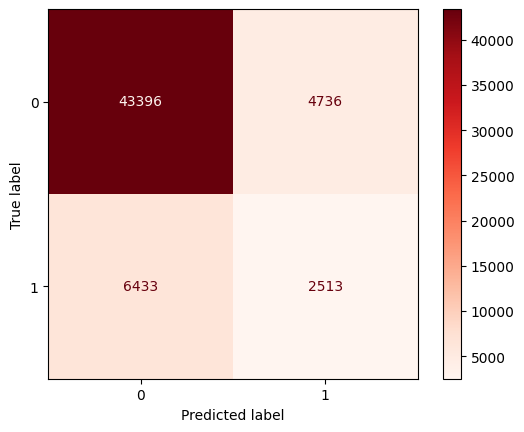

In [19]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

### XGBoost Classifier

In [20]:
xgb_classifier = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_classifier.fit(X_adasyn_sampled, y_adasyn_sampled)
print('Best score:', np.round(accuracy_score(y_test, xgb_classifier.predict(X_test)), 6))
evaluate_model(xgb_classifier)

Best score: 0.684905

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.69      0.79     48132
           1       0.28      0.66      0.40      8946

    accuracy                           0.68     57078
   macro avg       0.60      0.67      0.59     57078
weighted avg       0.82      0.68      0.73     57078



<Figure size 200x100 with 0 Axes>

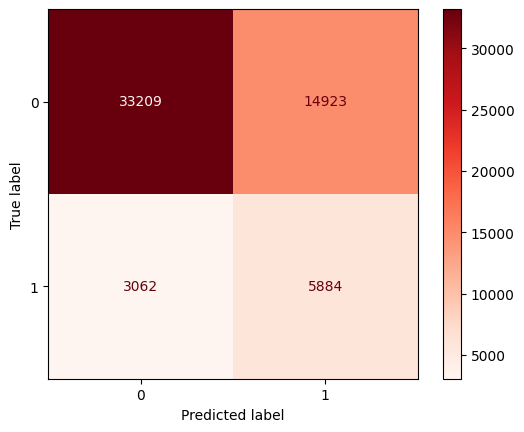

In [21]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

## Metrics

In [22]:
from sklearn import metrics
model_name = []
accuracy_score = []
f1_score = []
roc_auc_score = []
recall_score = []
precision_score = []
    
def metrics_models(name, model, X_test = X_test, y_test = y_test):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
        f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
        roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))


In [23]:
metrics_models('Base LinearRegression (Adasyn Oversample)', lr_baseline)
metrics_models('LinearRegression (Adasyn Oversample)', lr_model)
metrics_models('Base DecisionTreeClassifier (Adasyn Oversample)', tree_baseline)
metrics_models('DecisionTreeClassifier (Adasyn Oversample)', tree_model)
metrics_models('XGBoostClassifier (Adasyn Oversample)', xgb_classifier)

In [24]:
metric_df_adasyn = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'F1-score': f1_score,
                           'AUC': roc_auc_score,
                           'Recall': recall_score,
                           'Precision': precision_score})

In [25]:
metric_df_adasyn

,Model,Accuracy,F1-score,AUC,Recall,Precision
0,Base LinearRegression (Adasyn Oversample),0.685098,0.397493,0.676002,0.662754,0.283874
1,LinearRegression (Adasyn Oversample),0.690897,0.415388,0.694866,0.700648,0.295201
2,Base DecisionTreeClassifier (Adasyn Oversample),0.703213,0.314891,0.594100,0.435167,0.246705
3,DecisionTreeClassifier (Adasyn Oversample),0.804320,0.310343,0.591256,0.280908,0.346669
4,XGBoostClassifier (Adasyn Oversample),0.684905,0.395523,0.673840,0.657724,0.282789


LinearRegression (Adasyn Oversample) is indeed the best-performing model based on recall, F1-score, and AUC. It should be prioritized for further training and optimization.

XGBoostClassifier (Adasyn Oversample) can be considered a strong alternative, though it lags slightly behind in key metrics.

DecisionTreeClassifier Models perform poorly across multiple metrics and may not be suitable for this task without significant improvements.